In [1]:
import mechanize, os, re, csv, glob
import pandas as pd
import seaborn as sns
from collections import defaultdict

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import nltk
nltk.data.path.append('/media/shared_storage/data/nltk_data/')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [4]:
#For topic modelling and LSTM pre-processing

from gensim.models import LdaModel
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

#from nltk.text import ConcordanceIndex

from nltk.corpus import names as nltk_names

from nltk.tokenize import WhitespaceTokenizer  #, WordPunctTokenizer, TreebankWordTokenizer
from gensim.parsing import preprocessing

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [7]:
show_colour_dict = {'friends': '#66c2a5',
                 'frasier': '#fc8d62',
                 'wg': '#8da0cb',
                 'willandgrace': '#8da0cb',
                 'office': '#e78ac3',
                 'seinfeld': '#a6d854',
                 'marriedwc': '#ffd92f',
                 'scrubs': '#e5c494'}

## Make a ratings file or read in existing one

In [7]:
#from imdb import IMDb

#ia = IMDb()

#find out ids e.g.
#ia.search_movie('married with children')

#scrubs = 0285403
#friends = 0108778
#frasier = 0106004
#seinfeld = 0098904
#will and grace = 0157246
#the office = 0386676
#married with children = 0092400

In [8]:
# ratings = []
# for show, id in zip(['scrubs','friends','frasier','seinfeld','wg','office','marriedwc'],
#                     ['0285403','0108778','0106004','0098904','0157246','0386676','0092400']):
#     show_episodes = ia.get_movie(id, info=['episodes'])
    
#     ratings.append(pd.DataFrame([{'show': show,
#                                   'season': e['season'], 
#                                   'episode': e['episode'], 
#                                   'rating': e['rating'],
#                                   'votes': e['votes']} 
#                                  for season in show_episodes['episodes'].values() \
#                                  for e in season.values() \
#                                  if 'rating' in e.keys()]))

# ratings = pd.concat(ratings)

# ratings.to_csv('/home/david/projects/sitcoms/sitcom_episode_imdb_ratings.csv')

ratings = pd.read_csv('/home/david/projects/sitcoms/sitcom_episode_imdb_ratings.csv', index_col=0)

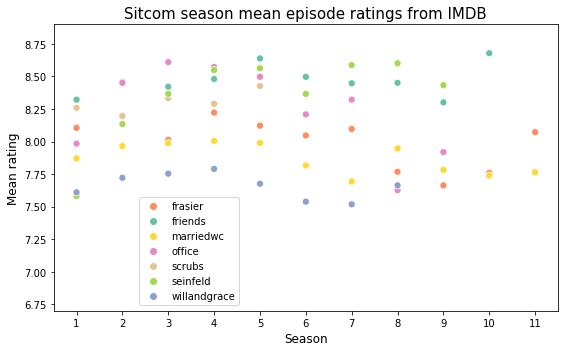

In [95]:
plot_data = ratings.groupby(['show','season']).rating.mean().reset_index()
plot_data['show'] = plot_data['show'].apply(lambda t: 'willandgrace' if t == 'wg' else t)
plot_data = plot_data[(~plot_data.show.isin(['willandgrace','scrubs'])) | 
                      ((plot_data.show=='scrubs') & (plot_data.season <= 5)) |
                      ((plot_data.show=='willandgrace') & (plot_data.season <= 8))]

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x='season', y='rating', hue='show', ax=ax,
                data = plot_data,
                palette = sns.color_palette([show_colour_dict[s] for s in plot_data.show.unique()]),
                s=50, marker='o')
ax.set_xlabel('Season', fontsize=12)
ax.set_ylabel('Mean rating', fontsize=12)
ax.set_title('Sitcom season mean episode ratings from IMDB', fontsize=15)

leghandles, leglabels = ax.get_legend_handles_labels()
ax.legend(leghandles[1:], leglabels[1:], title='', fontsize='medium', loc=(0.17,0.02))#(1.03,0.28))

plt.ylim(6.7,8.9)
_ = ax.set_xticks(list(range(1,12)))

plt.tight_layout()
plt.savefig('./post2_imdb_ratings_by_show_season.png')

In [125]:
#Clearly Frasier mean should not be below Friends and Scrubs
ratings.groupby(['show']).rating.mean().sort_values(ascending=False)

show
friends      8.464370
seinfeld     8.442275
office       8.250703
scrubs       8.135301
frasier      8.005417
marriedwc    7.863448
wg           7.672428
Name: rating, dtype: float64

## Functions

In [9]:
def get_clean_ep_sentences_by_character(ep_text, remove_stopwords=True, stopwords=STOPWORDS):
    
    char_sentence_dict = defaultdict(lambda : [])
    
    for line in ep_text:
        if 'DOCTYPE' in line or 'style type=' in line:
            continue
        
        line = line.rstrip('\n')

        #remove stage directions
        line = re.sub('\(.*\)', '', line)
        line = re.sub('\[.*\]', '', line)
        
        if line[:5] == 'Scene' or line[:5] == '(Note' or line[:7] == 'The One':
            continue
        elif len(line) > 0:
            character = line.split(':')[0].lower().strip()
            
            line = ' '.join(line.split(':')[1:]).strip()
            
            words = line.split(' ')
            words_clean = [re.sub('[^a-zA-Z0-9_\\s]', '', word.lower()) for word in words]
            if remove_stopwords:
                line = ' '.join([word for word in words_clean if word not in stopwords])
            else:
                line = ' '.join([word for word in words_clean])
            char_sentence_dict[character] += [line]
    return char_sentence_dict

In [10]:
#TODO add sentiment?

def get_ep_pos_statistics(ep_text):
    pos_dict = defaultdict(lambda: 0)
    
    for line in ep_text:
        if line.strip()[:5] == 'Scene' or line.strip()[:3] == 'Act':
            continue
        elif line[:5] == '(Note' or line[:7] == 'The One':
            continue
        elif 'DOCTYPE' in line or 'style type=' in line:
            continue
        else:
            line = line.rstrip('\n')

            #remove stage directions
            line = re.sub('\(.*\)', '', line)
            line = re.sub('\[.*\]', '', line)

            if ':' in line:                
                line = line.lower().split(':')[1].strip()
                
                for token in nlp(line):
                    if token.pos_ == 'NOUN':
                        pos_dict['nouns'] += 1
                    elif token.pos_ == 'VERB':
                        pos_dict['verbs'] += 1
                    elif token.pos_ == 'ADJ':
                        pos_dict['adjectives'] += 1
                    elif token.pos_ == 'PROPN' and token.text != "y'know":
                        pos_dict['proper_nouns'] += 1
    return pos_dict

In [11]:
def get_mean_word_length_from_clean_sentence(sentence):
    words = [w for w in sentence.split(' ') if w != '']
    return np.mean([len(w) for w in words])

main_char_lists = {'friends': ["chandler", "joey", "monica", "phoebe", "rachel", "ross"],
                   'frasier': ["daphne", "frasier", "martin", "niles", "roz"],
                   'wg': ["grace", "jack", "karen", "will"],
                   'office': ["dwight", "jim", "michael", "pam", "andy", "darryl", "erin", "ryan"],
                   'seinfeld': ["elaine", "george", "jerry", "kramer"],
                   'marriedwc': ["al", "kelly", "marcy", "peggy", "steve"],
                   'scrubs': ["carla", "elliot", "turk", "j.d.", "dr. cox", "dr. kelso"]}
all_main_chars = [c for l in main_char_lists.values() for c in l]

In [12]:
def get_clean_ep_scenes(ep_text, char_name_list_lower, keep_speakertoken=False):
    scene_docs = []
    this_scene = []
    tokenizer = WhitespaceTokenizer()
    names_re_pattern = re.compile('\\b{:s}\\b'.format('\\b|\\b'.join(char_name_list_lower)))
        
    for line in ep_text:
        if line.strip()[:5] == 'Scene' or line.strip()[:3] == 'Act':
            if this_scene != []:
                scene_docs.append(this_scene)
            this_scene = []
        elif line[:5] == '(Note' or line[:7] == 'The One':
            continue
        elif 'DOCTYPE' in line or 'style type=' in line:
            continue
        else:
            line = line.rstrip('\n')

            #remove stage directions
            line = re.sub('\(.*\)', '', line)
            line = re.sub('\[.*\]', '', line)

            if ':' in line:                
                line = line.split(':')[1].lower()
                
                if keep_speakertoken:
                    line = '_SPEAKERTOKEN_ ' + line
                
                line = re.sub(names_re_pattern, '_CHARACTERTOKEN_', re.sub('[\.\,\?\!]',' ',line))
                words_clean = preprocessing.preprocess_string(line)
                if 'everybody starts looking' in line:
                    print(words_clean)
            
                words_clean = [w for w in words_clean if w not in ['','nbsp']]
                
                this_scene += words_clean
    
    if this_scene != []:
        scene_docs.append(this_scene)
    
    return scene_docs

## Make a transcript summary file or read in existing one

In [13]:
# ep_summs = []

# for show in ['friends','frasier','wg','office','seinfeld','marriedwc','scrubs']:
#     ep_file_list = glob.glob('{:s}_transcripts/refmt_*txt'.format(show))

#     for ep_file in ep_file_list:
#         season = int(ep_file.split('refmt_')[1][:2])
#         ep = int(ep_file.split('refmt_')[1][2:4])

#         with open(ep_file, 'r', encoding='ISO-8859-1') as f:
#             ep_text = f.readlines()

#         char_ep_sentences = get_clean_ep_sentences_by_character(ep_text, remove_stopwords=False)

#         char_text_df = pd.DataFrame({'char': list(char_ep_sentences.keys()),
#                                      'num_lines': [len(char_ep_sentences[c]) for c in char_ep_sentences.keys()],
#                                      'text': [' '.join(char_ep_sentences[c]) for c in char_ep_sentences.keys()]})
#         #char_text_df = char_text_df[char_text_df.num_lines >= 3].reset_index()
#         char_text_df = char_text_df[char_text_df.text.str.strip() != '']
       
#         char_text_df['mean_word_length'] = char_text_df.text.apply(get_mean_word_length_from_clean_sentence)
        
#         row_dict = {'show': [show], 'season': [season], 'episode': [ep], 
#                     'text_bow_concat': ' '.join(char_text_df.text.tolist()),
#                     'tot_lines': [char_text_df.num_lines.sum()],
#                     'mean_words_per_line': [char_text_df.text.apply(lambda t: len(t.split(' '))).sum() / char_text_df.num_lines.sum()],
#                     'mean_word_length': [np.average(char_text_df['mean_word_length'], 
#                                                       weights=char_text_df['num_lines'])],
#                     'num_unique_words': len(set([w for l in char_text_df.text.str.split(' ').tolist() for w in l])),
#                     'num_characters': char_text_df[char_text_df.num_lines >= 3].char.nunique()
#                     }
#         res = []
#         for char in all_main_chars:
#             if char in main_char_lists[show] and char in char_text_df.char.unique():
#                 res.append(char_text_df[char_text_df.char == char].num_lines.iloc[0] / char_text_df.num_lines.sum())
#             else:
#                 res.append(0)
#         row_dict.update({c+'_frac': [frac] for c, frac in zip(all_main_chars,res)})
        
#         ep_pos_statistics = get_ep_pos_statistics(ep_text)
#         row_dict.update({'noun_verb_ratio': ep_pos_statistics['nouns']/ep_pos_statistics['verbs'],
#                          'noun_adjective_ratio': ep_pos_statistics['nouns']/ep_pos_statistics['adjectives']})
        
#         ep_summs.append(pd.DataFrame(row_dict))
    
# ep_summs = pd.concat(ep_summs).sort_values(['season','episode']).reset_index()
# ep_summs = ep_summs.drop('index', axis=1)
# ep_summs = ep_summs[['show','season','episode','text_bow_concat',
#                      'tot_lines','mean_words_per_line','mean_word_length',
#                      'num_unique_words','num_characters',
#                      'noun_verb_ratio', 'noun_adjective_ratio'] + [c+'_frac' for c in all_main_chars]]

# ep_summs.to_csv('/home/david/projects/sitcoms/sitcom_episode_summary_details.csv')

ep_summs = pd.read_csv('/home/david/projects/sitcoms/sitcom_episode_summary_details.csv', index_col=0)

In [14]:
ep_summs.groupby('show')[['noun_verb_ratio','noun_adjective_ratio']].mean()

,noun_verb_ratio,noun_adjective_ratio
show,,
frasier,0.693592,1.944370
friends,0.608412,2.033353
marriedwc,0.761867,2.419789
office,0.750177,2.219611
scrubs,0.725248,2.055247
seinfeld,0.819367,2.854003
wg,0.682886,2.112788


## Fit a linear reg model on summary columns only

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import Lasso, LinearRegression, ElasticNetCV

In [16]:
ep_summs.head()

,show,season,episode,text_bow_concat,tot_lines,mean_words_per_line,mean_word_length,num_unique_words,num_characters,noun_verb_ratio,...,carla_frac,elliot_frac,turk_frac,j.d._frac,dr. cox_frac,dr. kelso_frac,elaine_frac,george_frac,jerry_frac,kramer_frac
0,friends,1,1,goodnight oh yeah had that dream hey paul hi t...,294,10.632653,3.855260,785,9,0.625298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,wg,1,1,hanging out will i cant of course i want to bu...,278,9.525180,3.851582,720,8,0.653425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,office,1,1,well it could be out of your hands michael can...,229,11.537118,3.986157,719,10,0.641536,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,seinfeld,1,1,what does she look like what actress does she ...,349,8.441261,3.932727,688,11,0.763369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.151862,0.083095,0.461318,0.014327
4,marriedwc,1,1,ken stump stephen kolzak marti masamitsu don r...,256,11.140625,4.033562,767,8,0.712418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [17]:
traintest = ep_summs.merge(ratings, how='inner', on=['show','season','episode'])

traintest = traintest.join(pd.get_dummies(traintest['show']))

In [26]:
def fit_glm_elasticnet_print_coefs(X_train, X_test, y_train, y_test):    

    my_glm = LinearRegression()
    my_glm.fit(X = X_train,
               y = y_train)
    print('\nGLM: Corr = {:.3f}, RMSE = {:.4f} \nCoefs:'.format(my_glm.score(X_test, y_test),
                                                                ((y_test - my_glm.predict(X_test))**2).mean()**0.5))
    print('Intercept: {:.2f}'.format(my_glm.intercept_))
    for i in range(len(feature_cols)):
        print('{:s}: {:.5f}'.format(feature_cols[i], my_glm.coef_[i]))

    my_encv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1.0])
    my_encv.fit(X = X_train,
               y = y_train)
    print('\nElasticNet CV (l1={:.2f}, alpha={:.2f}): Corr = {:.3f}, RMSE = {:.4f} \nCoefs:'.format(
        my_encv.l1_ratio_, my_encv.alpha_,
        my_encv.score(X_test, y_test),
        ((y_test - my_encv.predict(X_test))**2).mean()**0.5
    ))
    print('Intercept: {:.2f}'.format(my_encv.intercept_))
    for i in range(len(feature_cols)):
        print('{:s}: {:.5f}'.format(feature_cols[i], my_encv.coef_[i]))


In [65]:
np.zeros(y_test.shape)[X_test['wg']==1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [59]:
show_train_means

{'frasier': 7.987224906055259,
 'friends': 8.435366304417949,
 'marriedwc': 7.916975308631736,
 'office': 8.27115326707799,
 'scrubs': 8.270567901224332,
 'seinfeld': 8.443982659494049,
 'wg': 7.647277733358621}

In [69]:
all(np.array((1,2,3)) > 23)

False

In [71]:
feature_cols = ['tot_lines','mean_words_per_line','mean_word_length','num_unique_words','num_characters',
                'noun_verb_ratio','noun_adjective_ratio',
                'season',
                'frasier','friends','marriedwc','office','scrubs','seinfeld','wg']

X_train, X_test, y_train, y_test = train_test_split(traintest[feature_cols], traintest['rating'], 
                                                    test_size=0.25, random_state=6000)

#Baseline
print('Baseline (predict train mean of {:.2f}): RMSE = {:.4f}'.format(
        y_train.mean(), np.mean((y_train.mean() - y_test)**2)**0.5
    ))

#Better baseline
show_train_means = {show: y_train[X_train[show]==1].mean() for show in ['frasier','friends','marriedwc','office','scrubs','seinfeld','wg']}
baseline_show_train_means = np.zeros(y_test.shape)
for show in ['frasier','friends','marriedwc','office','scrubs','seinfeld','wg']:
    baseline_show_train_means[X_test[show]==1] = show_train_means[show]
assert all(baseline_show_train_means > 7)
print('Baseline (predict train means by show): RMSE = {:.4f}'.format(
        np.mean((baseline_show_train_means - y_test)**2)**0.5
    ))

fit_glm_elasticnet_print_coefs(X_train, X_test, y_train, y_test)

Baseline (predict train mean of 8.13): RMSE = 0.5256
Baseline (predict train means by show): RMSE = 0.4469

GLM: Corr = 0.349, RMSE = 0.4227 
Coefs:
Intercept: 8.86
tot_lines: 0.00201
mean_words_per_line: 0.00628
mean_word_length: -0.32228
num_unique_words: -0.00080
num_characters: 0.00404
noun_verb_ratio: 0.93880
noun_adjective_ratio: -0.01678
season: -0.01935
frasier: -0.03683
friends: 0.26341
marriedwc: -0.18503
office: 0.07788
scrubs: 0.13594
seinfeld: 0.18174
wg: -0.43711

ElasticNet CV (l1=1.00, alpha=0.01): Corr = 0.329, RMSE = 0.4291 
Coefs:
Intercept: 8.08
tot_lines: 0.00198
mean_words_per_line: -0.00998
mean_word_length: 0.00000
num_unique_words: -0.00068
num_characters: 0.01573
noun_verb_ratio: 0.00000
noun_adjective_ratio: 0.06116
season: -0.02009
frasier: -0.00000
friends: 0.12570
marriedwc: -0.01236
office: 0.00000
scrubs: 0.00000
seinfeld: 0.11014
wg: -0.33579


More lines is good - may be double episodes. Number unique words is slightly bad.

In [31]:
feature_cols = ['tot_lines','mean_words_per_line','mean_word_length','num_unique_words','num_characters',
                'noun_verb_ratio','noun_adjective_ratio',
                'season',
                'frasier','friends','marriedwc','office','scrubs','seinfeld','wg'] + [c+'_frac' for c in all_main_chars]

X_train, X_test, y_train, y_test = train_test_split(traintest[feature_cols], traintest['rating'], 
                                                    test_size=0.25, random_state=6000)

fit_glm_elasticnet_print_coefs(X_train, X_test, y_train, y_test)


GLM: Corr = 0.385, RMSE = 0.4110 
Coefs:
Intercept: 9.31
tot_lines: 0.00106
mean_words_per_line: -0.01438
mean_word_length: -0.49844
num_unique_words: -0.00019
num_characters: 0.01659
noun_verb_ratio: 0.84407
noun_adjective_ratio: -0.04017
season: -0.01136
frasier: -0.64548
friends: -0.08887
marriedwc: 0.13586
office: 0.16542
scrubs: 0.76235
seinfeld: 0.23167
wg: -0.56095
daphne_frac: 2.31869
frasier_frac: 0.92039
martin_frac: 0.65643
niles_frac: 1.34557
roz_frac: 0.03771
carla_frac: -1.93619
elliot_frac: -1.53947
turk_frac: 1.43916
j.d._frac: -1.04695
dr. cox_frac: -2.55767
dr. kelso_frac: 3.84029
elaine_frac: 0.22041
george_frac: 1.15527
jerry_frac: -1.10357
kramer_frac: 2.01349
chandler_frac: 0.06012
joey_frac: 0.37999
monica_frac: 1.54456
phoebe_frac: 1.24567
rachel_frac: 0.15748
ross_frac: 0.94628
grace_frac: 0.51544
jack_frac: 0.53197
karen_frac: 0.71200
will_frac: 0.18063
dwight_frac: 0.53239
jim_frac: -0.15684
michael_frac: 1.62668
pam_frac: -2.03197
andy_frac: -0.27681
darryl

Character fractions make it slightly better but need R glm to see which are significant.

Now add words TFM.

In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [33]:
bow_vec = CountVectorizer(max_features = 100,
                          max_df = 0.5,
                          min_df = 10,
                          ngram_range = (1,2),
                          stop_words = all_main_chars + ['bud','crane','bundy','kevin','maris','jerrys',   
                                                         'nbsp'])
traintest_tfm = bow_vec.fit_transform(traintest['text_bow_concat']).toarray()

In [34]:
traintest_w_tfm = traintest.join(pd.DataFrame(data=traintest_tfm,
                                              columns=['token_count_'+t for t in bow_vec.get_feature_names()]))

In [35]:
traintest_w_tfm.head()

,show,season,episode,text_bow_concat,tot_lines,mean_words_per_line,mean_word_length,num_unique_words,num_characters,noun_verb_ratio,...,token_count_want you,token_count_we are,token_count_week,token_count_well im,token_count_what happened,token_count_yeah yeah,token_count_year,token_count_yknow,token_count_you mean,token_count_you oh
0,friends,1,1,goodnight oh yeah had that dream hey paul hi t...,294,10.632653,3.855260,785,9,0.625298,...,1,1,1,0,0,3,1,9,1,1
1,wg,1,1,hanging out will i cant of course i want to bu...,278,9.525180,3.851582,720,8,0.653425,...,3,0,0,2,0,1,1,0,2,2
2,office,1,1,well it could be out of your hands michael can...,229,11.537118,3.986157,719,10,0.641536,...,0,0,1,0,0,4,0,0,1,0
3,seinfeld,1,1,what does she look like what actress does she ...,349,8.441261,3.932727,688,11,0.763369,...,0,0,0,0,0,2,0,11,2,1
4,marriedwc,1,1,ken stump stephen kolzak marti masamitsu don r...,256,11.140625,4.033562,767,8,0.712418,...,1,0,3,0,0,0,1,1,0,0


In [36]:
#Just the term frequencies

feature_cols = [c for c in traintest_w_tfm if 'token_count_' in c]
X_train, X_test, y_train, y_test = train_test_split(traintest_w_tfm[feature_cols], 
                                                    traintest_w_tfm['rating'], 
                                                    test_size = 0.25, 
                                                    random_state = 6000)
fit_glm_elasticnet_print_coefs(X_train, X_test, y_train, y_test)


GLM: Corr = 0.093, RMSE = 0.4991 
Coefs:
Intercept: 8.06
token_count_alright: 0.01104
token_count_also: -0.00718
token_count_apartment: 0.01140
token_count_baby: 0.00618
token_count_bring: -0.02463
token_count_business: 0.02431
token_count_cant believe: 0.01673
token_count_car: 0.00430
token_count_check: 0.02060
token_count_coffee: 0.00728
token_count_comes: -0.00246
token_count_cool: 0.02518
token_count_couple: -0.02054
token_count_crazy: -0.01033
token_count_dad: -0.00622
token_count_date: -0.00149
token_count_deal: 0.00481
token_count_dinner: 0.00295
token_count_do this: -0.02016
token_count_doctor: 0.00194
token_count_door: -0.00044
token_count_dr: 0.00938
token_count_eat: 0.01237
token_count_em: -0.00077
token_count_exactly: -0.03033
token_count_family: 0.01200
token_count_father: 0.00725
token_count_few: -0.02556
token_count_forget: -0.00797
token_count_found: 0.02270
token_count_game: 0.00766
token_count_gay: -0.02182
token_count_get it: 0.00898
token_count_get out: 0.01690
tok

In [43]:
#Term frequencies and summary terms

feature_cols = ['tot_lines','mean_words_per_line','mean_word_length','num_unique_words','num_characters','season',
                'noun_verb_ratio','noun_adjective_ratio',
                'frasier','friends','marriedwc','office','scrubs','seinfeld','wg'] + [c+'_frac' for c in all_main_chars]
feature_cols += [c for c in traintest_w_tfm if 'token_count_' in c]

X_train, X_test, y_train, y_test = train_test_split(traintest_w_tfm[feature_cols], 
                                                    traintest_w_tfm['rating'], 
                                                    test_size = 0.25, 
                                                    random_state = 6000)
fit_glm_elasticnet_print_coefs(X_train, X_test, y_train, y_test)


GLM: Corr = 0.292, RMSE = 0.4410 
Coefs:
Intercept: 8.94
tot_lines: 0.00149
mean_words_per_line: -0.01032
mean_word_length: -0.40565
num_unique_words: -0.00016
num_characters: 0.01686
season: -0.01760
noun_verb_ratio: 0.80910
noun_adjective_ratio: -0.04355
frasier: -0.64971
friends: 0.06200
marriedwc: 0.09618
office: 0.08272
scrubs: 0.76201
seinfeld: 0.39745
wg: -0.75065
daphne_frac: 2.10407
frasier_frac: 0.82142
martin_frac: 0.62896
niles_frac: 1.43321
roz_frac: 0.00452
carla_frac: -2.00408
elliot_frac: -1.33279
turk_frac: 1.86079
j.d._frac: -1.47876
dr. cox_frac: -2.99986
dr. kelso_frac: 3.54606
elaine_frac: -0.03194
george_frac: 0.79031
jerry_frac: -0.97063
kramer_frac: 1.76201
chandler_frac: 0.43762
joey_frac: -0.00823
monica_frac: 1.28934
phoebe_frac: 1.89089
rachel_frac: -0.26287
ross_frac: 0.66914
grace_frac: 0.79875
jack_frac: 0.66589
karen_frac: 0.89445
will_frac: 0.42326
dwight_frac: 0.55313
jim_frac: 0.19010
michael_frac: 1.42437
pam_frac: -1.82051
andy_frac: -0.13981
darry

Bag-of-words columns don't help the fit. Whatever information they have is probably contained in the show and character fraction columns already.

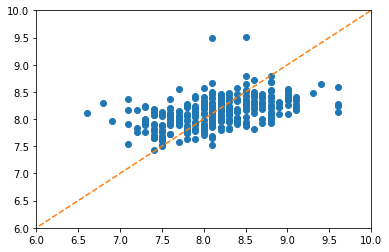

In [374]:
plt.plot(y_test, my_encv.predict(X_test), 'o')
#plt.plot(y_train, cross_val_predict(my_lasso, X_train, y_train, cv=2), 'o')
plt.plot([0,10],[0,10],'--')
plt.xlim(6,10)
_ = plt.ylim(6,10)

More lines is good - may be double episodes. Number unique words is slightly bad.

## Topic model on scenes

In [559]:
preprocessing.preprocess_string("There's nothing to tell it's just a guy joey runs over ran running __CHARACTERTOKEN__")

['tell', 'gui', 'joei', 'run', 'ran', 'run', 'charactertoken']

In [ ]:
scenes_df = []

for show in ['friends','frasier','wg','office','seinfeld','marriedwc','scrubs']:
    ep_file_list = glob.glob('{:s}_transcripts/refmt_*txt'.format(show))

    for ep_file in ep_file_list:
        season = int(ep_file.split('refmt_')[1][:2])
        ep = int(ep_file.split('refmt_')[1][2:4])

        with open(ep_file, 'r', encoding='ISO-8859-1') as f:
            ep_text = f.readlines()

        scene_texts = get_clean_ep_scenes(ep_text, 
                                          all_main_chars + [n.lower() for n in nltk_names.words()]), 
                                          #remove_stopwords=True, stopwords=STOPWORDS)
        
        row_dict = {'show': [show]*len(scene_texts), 
                    'season': [season]*len(scene_texts), 
                    'episode': [ep]*len(scene_texts),
                    'scene_num': range(1,len(scene_texts)+1), 
                    'scene_text': scene_texts
                    }
        scenes_df.append(pd.DataFrame(row_dict))
    
scenes_df = pd.concat(scenes_df).sort_values(['season','episode','scene_num']).reset_index()
scenes_df = scenes_df.drop('index', axis=1)
scenes_df = scenes_df[['show','season','episode','scene_num','scene_text']]

In [596]:
common_dictionary = Dictionary(scenes_df.scene_text.tolist())
common_dictionary.filter_extremes(no_below=5, no_above=0.2, keep_n=1000)
common_corpus = [common_dictionary.doc2bow(text) for text in scenes_df.scene_text.tolist()]

In [597]:
my_lda = LdaModel(common_corpus, num_topics=20)

In [598]:
for tnum in range(my_lda.num_topics):
    print('{:d}: {:s}'.format(tnum, ', '.join([(common_dictionary[i[0]]) for i in my_lda.get_topic_terms(tnum)])))

0: tma, und, pie, friend, home, ent, ment, tion, bring, present
1: date, meet, int, woman, hello, loo, friend, yfriend, old, phone
2: car, hello, room, â, crane, ticket, wife, old, life, guess
3: umm, best, friend, room, pap, bu, wow, guess, live, isn
4: crane, hello, bye, help, stop, dad, ic, aft, won, phone
5: offic, phone, ut, tape, voic, hit, ent, funni, head, hello
6: dad, help, home, old, birthdai, mom, aft, ght, morn, life
7: kei, friend, eat, door, ring, scene, gotta, mail, und, ent
8: dad, cours, hello, aft, crane, chair, wond, told, tion, fath
9: monei, ar, daddi, car, bui, thousand, pai, hous, hundr, bundi
10: scene, car, stop, pictur, huh, point, hard, monei, bra, girl
11: door, ment, wear, shot, the, turn, ent, heard, girlfriend, coffe
12: dent, pre, fine, friend, sound, tot, lot, aunt, pheeb, won
13: whoa, und, girl, sex, lot, wow, ryth, offic, life, togeth
14: newman, huh, guess, cop, wow, hear, goodby, high, hard, ooh
15: tion, excus, ent, miss, loo, heard, lot, ut, b

In [648]:
scenes_df['most_likely_topic'] = [max(my_lda[p], key=lambda item: item[1])[0] for p in common_corpus]

In [697]:
traintest = ep_summs.merge(ratings, how='inner', on=['show','season','episode'])
traintest = traintest.join(pd.get_dummies(traintest['show']))

for tnum in range(my_lda.num_topics):
    traintest = traintest.merge(
        scenes_df.groupby(['show','season','episode']).agg({'most_likely_topic': lambda t: np.mean(t == tnum)}).reset_index()\
            .rename(columns={'most_likely_topic': 'ep_frac_topic_'+str(tnum)}, index=str),
        on = ['show','season','episode'], how='inner'
    )

In [698]:
traintest.head()

,show,season,episode,text_bow_concat,tot_lines,mean_words_per_line,mean_word_length,num_unique_words,num_characters,elaine_frac,...,ep_frac_topic_10,ep_frac_topic_11,ep_frac_topic_12,ep_frac_topic_13,ep_frac_topic_14,ep_frac_topic_15,ep_frac_topic_16,ep_frac_topic_17,ep_frac_topic_18,ep_frac_topic_19
0,friends,1,1,goodnight all right joey be nice so does he ha...,294,10.632653,3.855260,785,9,0.000000,...,0.000000,0.133333,0.000000,0.0,0.000000,0.0,0.0,0.2,0.133333,0.00
1,wg,1,1,im going to sleep yeah yay aww oh yeah yeah yo...,278,9.525180,3.851582,720,8,0.000000,...,0.083333,0.000000,0.083333,0.0,0.083333,0.0,0.0,0.0,0.166667,0.00
2,office,1,1,are you sure about that hey ryan howard from t...,229,11.537118,3.986157,719,10,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,1.00
3,seinfeld,1,1,cheque so im on line at the supermarket two wo...,349,8.441261,3.932727,688,11,0.151862,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.25
4,marriedwc,1,1,richard draney gary ramirez don roberts andre...,256,11.140625,4.033562,767,8,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00


Fit model but include the show column features so that topics are somehwat independent of show

In [702]:
print('Baseline (predict train mean of {:.2f}): RMSE = {:.4f}'.format(
    y_train.mean(), np.mean((y_train.mean() - y_test)**2)**0.5
))


feature_cols = ['frasier', 'friends', 'marriedwc', 'office', 'scrubs', 'seinfeld', 'wg']

X_train, X_test, y_train, y_test = train_test_split(traintest[feature_cols], 
                                                    traintest['rating'], 
                                                    test_size=0.25, 
                                                    random_state=0)

my_glm = LinearRegression()
my_glm.fit(X = X_train,
           y = y_train)
print('\nGLM, show columns: Corr = {:.3f}, RMSE = {:.4f} \nCoefs:'.format(cross_val_score(my_glm, X_train, y_train, cv=10).mean(),
                                                          (-1*cross_val_score(my_glm, X_train, y_train, cv=10,
                                                                         scoring='neg_mean_squared_error').mean())**0.5))
print('Intercept: {:.2f}'.format(my_glm.intercept_))
for i in range(len(feature_cols)):
    print('{:s}: {:.5f}'.format(feature_cols[i], my_glm.coef_[i]))

    
feature_cols = [c for c in traintest if 'ep_frac_topic_' in c] + ['frasier', 'friends', 'marriedwc', 'office', 'scrubs', 'seinfeld', 'wg']

X_train, X_test, y_train, y_test = train_test_split(traintest[feature_cols], 
                                                    traintest['rating'], 
                                                    test_size=0.25, 
                                                    random_state=0)

my_glm = LinearRegression()
my_glm.fit(X = X_train,
           y = y_train)
print('\nGLM, show + topic columns: Corr = {:.3f}, RMSE = {:.4f} \nCoefs:'.format(cross_val_score(my_glm, X_train, y_train, cv=10).mean(),
                                                          (-1*cross_val_score(my_glm, X_train, y_train, cv=10,
                                                                         scoring='neg_mean_squared_error').mean())**0.5))
print('Intercept: {:.2f}'.format(my_glm.intercept_))
for i in range(len(feature_cols)):
    print('{:s}: {:.5f}'.format(feature_cols[i], my_glm.coef_[i]))


# my_encv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1.0], cv=5)
# my_encv.fit(X = X_train,
#            y = y_train)
# print('\nElasticNet CV (l1={:.2f}, alpha={:.2f}), just token columns, test: Corr = {:.3f}, RMSE = {:.4f} \nCoefs:'.format(
#     my_encv.l1_ratio_, my_encv.alpha_,
#     my_encv.score(X_test, y_test),
#     ((y_test - my_encv.predict(X_test))**2).mean()**0.5
# ))

Baseline (predict train mean of 8.14): RMSE = 0.5202

GLM, show columns: Corr = 0.274, RMSE = 0.4318 
Coefs:
Intercept: -41331716546524.66
frasier: 41331716546532.67188
friends: 41331716546533.09375
marriedwc: 41331716546532.57031
office: 41331716546532.92969
scrubs: 41331716546532.93750
seinfeld: 41331716546533.06250
wg: 41331716546532.29688

GLM, show + topic columns: Corr = 0.269, RMSE = 0.4337 
Coefs:
Intercept: -8337775560839.88
ep_frac_topic_0: 0.02001
ep_frac_topic_1: 0.19130
ep_frac_topic_2: 0.53472
ep_frac_topic_3: 0.15907
ep_frac_topic_4: -0.18423
ep_frac_topic_5: 0.14388
ep_frac_topic_6: 0.10806
ep_frac_topic_7: 0.08074
ep_frac_topic_8: -0.04529
ep_frac_topic_9: -0.02096
ep_frac_topic_10: 0.07238
ep_frac_topic_11: -0.08930
ep_frac_topic_12: -0.50257
ep_frac_topic_13: -0.00886
ep_frac_topic_14: -0.16127
ep_frac_topic_15: -0.22039
ep_frac_topic_16: -0.15349
ep_frac_topic_17: 0.14299
ep_frac_topic_18: -0.08463
ep_frac_topic_19: -0.11263
frasier: 8337775560847.88867
friends: 833

Topics don't add anything to GLM. 'Best' topics is 2 (frasier/seinfeld), worst is 12 (mixture).

In [705]:
scenes_df.groupby('show').agg({'most_likely_topic': lambda t: np.mean(t == 12)})

,most_likely_topic
show,
frasier,0.016571
friends,0.046835
marriedwc,0.014100
office,0.000000
scrubs,0.039900
seinfeld,0.026810
wg,0.042228


## LSTM to predict ratings

In [73]:
#Fit best model above and create residuals for training and test
feature_cols = ['tot_lines','mean_words_per_line','mean_word_length','num_unique_words','num_characters',
                'noun_verb_ratio','noun_adjective_ratio',
                'season',
                'frasier','friends','marriedwc','office','scrubs','seinfeld','wg'] + [c+'_frac' for c in all_main_chars]

X_train, X_test, y_train, y_test = train_test_split(traintest[feature_cols], traintest['rating'], 
                                                    test_size=0.25, random_state=6000)

best_summ_glm = LinearRegression()
best_summ_glm.fit(X = X_train, y = y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

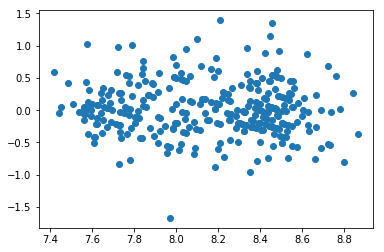

In [120]:
#can recover show, season, and episode from traintest, using the right indexing
best_summ_glm_resids_train = traintest.iloc[X_train.index][['show','season','episode']]
best_summ_glm_resids_train['residual'] = y_train - best_summ_glm.predict(X_train)
best_summ_glm_resids_test = traintest.iloc[X_test.index][['show','season','episode']]
best_summ_glm_resids_test['residual'] = y_test - best_summ_glm.predict(X_test)

#Confirm that residuals are random against the test predictions
plt.plot(best_summ_glm.predict(X_test), best_summ_glm_resids_test['residual'], 'o')

In [82]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Embedding, Bidirectional, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.activations import sigmoid, tanh, softmax
import keras.backend as K
from keras.preprocessing import sequence
from keras.preprocessing.text import one_hot 
from keras.optimizers import Adam

#from sklearn.preprocessing import LabelEncoder

/home/david/anaconda3/envs/python3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [59]:
max_features = 20000

# the longest sequence to consider - will do WHAT do longer ones?
#Episodes are typically around 1000 tokens in length
maxlen = 1250

For input we need the text in order, then label encode it. Use a similar method to scenes_df from section 4 above. 

TODO 
- Probably would be better if not removing stop words
- Use different tokens for each character speaking?

In [91]:
scenes_df = []

for show in ['friends','frasier','wg','office','seinfeld','marriedwc','scrubs']:
    ep_file_list = glob.glob('{:s}_transcripts/refmt_*txt'.format(show))

    for ep_file in ep_file_list:
        season = int(ep_file.split('refmt_')[1][:2])
        ep = int(ep_file.split('refmt_')[1][2:4])

        with open(ep_file, 'r', encoding='ISO-8859-1') as f:
            ep_text = f.readlines()

        scene_texts = get_clean_ep_scenes(ep_text, 
                                          all_main_chars + [n.lower() for n in nltk_names.words()],
                                          keep_speakertoken = True), 
        scene_texts = scene_texts[0]
        
        row_dict = {'show': [show]*len(scene_texts), 
                    'season': [season]*len(scene_texts), 
                    'episode': [ep]*len(scene_texts),
                    'scene_num': range(1,len(scene_texts)+1), 
                    'scene_text': scene_texts
                    }
        scenes_df.append(pd.DataFrame(row_dict))
    
scenes_df = pd.concat(scenes_df).sort_values(['season','episode','scene_num']).reset_index()
scenes_df = scenes_df.drop('index', axis=1)
scenes_df = scenes_df[['show','season','episode','scene_num','scene_text']]

['speakertoken', 'sudden', 'phone', 'start', 'ring', 'charactertoken', 'know', 'everybodi', 'start', 'look']


In [60]:
lstm_X_traintest = scenes_df.groupby(['show','season','episode'])\
    .agg({'scene_text': lambda l: [a for b in l for a in b]}).reset_index()

lstm_X_traintest = lstm_X_traintest.merge(ratings, how='inner', on=['show','season','episode'])
#Lose 5 cases with no ratings here

#will actually just use the scene_text column for X, which is now the whole ep_text
lstm_y_traintest = np.array(lstm_X_traintest['rating'].tolist())

lstm_X_traintest = lstm_X_traintest[['scene_text']]
lstm_X_traintest.columns = ['ep_text']

assert lstm_X_traintest.shape[0] == lstm_y_traintest.shape[0]

In [21]:
#Each row is the full episode text, stemmed and without stop words, with speaker and character/name tokens
#lstm_X_traintest.ep_text.iloc[0]

Convert strings to integer labels

In [164]:
# ep_texts_dictionary = Dictionary(lstm_X_traintest.ep_text.tolist())
# ep_texts_dictionary.filter_extremes(no_below = 5,
#                                     no_above = 1.0,  #to keep speakertoken, charactertoken
#                                     keep_n = max_features)
# print('{:d} documents (episodes), {:d} unique tokens'.format(ep_texts_dictionary.num_docs, len(ep_texts_dictionary)))

227 documents (episodes), 2469 unique tokens


In [165]:
# #This puts -1s for the tokens that were dropped from the dictionary above - probably OK
# lstm_X_traintest = [ep_texts_dictionary.doc2idx(text) for text in lstm_X_traintest.ep_text.tolist()]

In [61]:
#Or use the Keras one_hot function, which takes a string rather than tokenized string as input
#Despite operating once per document, it keeps a consistent hashing of tokens across the corpus
lstm_X_traintest = [one_hot(' '.join(d), max_features) for d in lstm_X_traintest.ep_text.tolist()]

In [62]:
len(lstm_X_traintest[0])

1200

Pad the input sequences to handle the different lengths. This uses keras.preprocessing.sequence.pad_sequences which transforms a list of num_samples sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps).

In [63]:
lstm_X_traintest = sequence.pad_sequences(lstm_X_traintest, maxlen=maxlen, padding='pre', truncating='pre')

In [64]:
lstm_X_train, lstm_X_test, lstm_y_train, lstm_y_test = train_test_split(lstm_X_traintest, lstm_y_traintest,
                                                                        test_size = 0.2,
                                                                        random_state = 54402)

print('lstm_X_train shape:', lstm_X_train.shape)
print('lstm_X_test shape:', lstm_X_test.shape)

#Remove mean from ratings to take away this part of the prediction skill
lstm_y_test = lstm_y_test - lstm_y_train.mean()
lstm_y_train = lstm_y_train - lstm_y_train.mean()

lstm_X_train shape: (1013, 1250)
lstm_X_test shape: (254, 1250)


Now have input of the right form. Rather than one-hot encode each term, use an embedding layer to convert to 128 dimension, then try a LSTM outputting dim 64 and then a Dense layer to reduce to dim 1. Output is continuous so use MSE as loss.

In [65]:
max(lstm_X_train[1])

19975

In [71]:
embedding_dim = 128

eprating_lstm = Sequential()
eprating_lstm.add(Embedding(max_features, embedding_dim, input_length=maxlen))
#
eprating_lstm.add(LSTM(64, 
                   return_sequences=False,
                   activation='tanh'))
# eprating_lstm.add(Flatten())
# eprating_lstm.add(Dense(64,activation='relu'))
#
eprating_lstm.add(Dropout(0.5))
eprating_lstm.add(Dense(1))  #no activation function, for regression prediction?

#Using the Keras IMDB sent class example - breaks kernel
# kernel_size=5
# filters=64
# pool_size=4
# eprating_lstm = Sequential()
# eprating_lstm.add(Embedding(max_features, embedding_dim, input_length=maxlen))
# eprating_lstm.add(Dropout(0.25))
# eprating_lstm.add(Conv1D(filters,
#                  kernel_size,
#                  padding='valid',
#                  activation='relu',
#                  strides=1))
# eprating_lstm.add(MaxPooling1D(pool_size=pool_size))
# eprating_lstm.add(LSTM(64))
# eprating_lstm.add(Dense(1))  #no activation function, for regression prediction?

eprating_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1250, 128)         2560000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 2,609,473
Trainable params: 2,609,473
Non-trainable params: 0
_________________________________________________________________


In [72]:
eprating_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=[])

Train on 1013 samples, validate on 254 samples
Epoch 1/5
1013/1013 [==============================] - 75s 74ms/step - loss: 0.2609 - val_loss: 0.2791
Epoch 2/5
1013/1013 [==============================] - 97s 96ms/step - loss: 0.2376 - val_loss: 0.2846
Epoch 3/5
1013/1013 [==============================] - 136s 134ms/step - loss: 0.1620 - val_loss: 0.3180
Epoch 4/5
1013/1013 [==============================] - 134s 132ms/step - loss: 0.0986 - val_loss: 0.3352
Epoch 5/5
1013/1013 [==============================] - 97s 96ms/step - loss: 0.0580 - val_loss: 0.3302


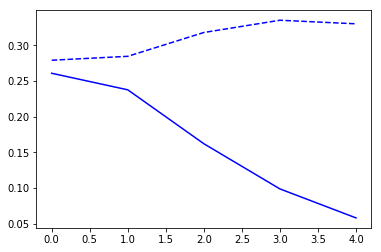

In [73]:
train_history_eprating_lstm = eprating_lstm.fit(lstm_X_train, lstm_y_train,
                                                batch_size=32, epochs=5,
                                                validation_data = [lstm_X_test, lstm_y_test],
                                                verbose=1)

plt.plot(train_history_eprating_lstm.history['loss'], 'b')
# plt.plot(train_history.history['acc'], color='orange')
plt.plot(train_history_eprating_lstm.history['val_loss'], 'b--')
# plt.plot(train_history.history['val_acc'], '--', color='orange')

In [ ]:
#Friends only:
# Using one_hot encoding:
#  max_len=250, embedding_dim 32, LSTM+Dropout0.5 does fit but overfits to training; test corr 0.13
#    Using test as validation set can see that loss doesn't decrease at all
#  max_len=250, embedding_dim 128, LSTM+Dropout0.5 also doesn't decrease valid loss
#  Keras docs Conv1D setup: breaks kernel
# Not surprising as the first 250 words shouldn't be very predictive
#  max_len=2500, embedding_dim 32, LSTM+Dropout0.5 just predicts mean; no skill on test

#All sitcomes (n_train = 1013)
# max_features=20000, max_len=250, emb=32, LSTM(64)+Dropout0.5: not reducing valid loss
#   change to max_features=1000: no better
#   change to max_len=1250: 
#   change to max_len=1250 and emb=128:


In [112]:
eprating_lstm.evaluate(lstm_X_test, lstm_y_test)

46/46 [==============================] - 0s 466us/step


0.17680423220862512

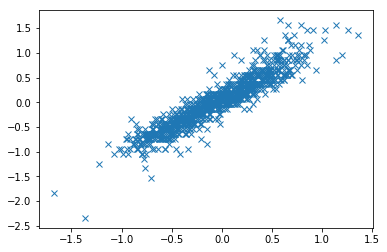

In [69]:
plt.plot(eprating_lstm.predict(lstm_X_train), lstm_y_train, 'x')
#plt.xlim([5,10])
#_ = plt.ylim([5,10])

[[1.         0.00550677]
 [0.00550677 1.        ]]


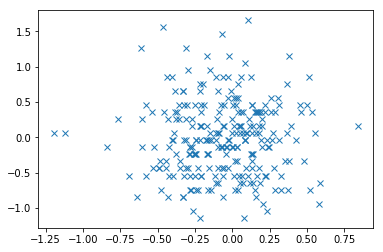

In [70]:
print(np.corrcoef(eprating_lstm.predict(lstm_X_test).flatten(), lstm_y_test))

plt.plot(eprating_lstm.predict(lstm_X_test), lstm_y_test, 'x')

### Change approach and use each scene as a row to get bigger training size. 

There is little point in connection sequences across scenes anyway. The thinking here is that episode's quality should go by writer, so we can attribute a high episode score to every scene of the episode.

In [200]:
max_features = 10000
maxlen = 200

In [216]:
# lstm_X_traintest = scenes_df.groupby(['show','season','episode'])\
#     .agg({'scene_text': lambda l: [a for b in l for a in b]}).reset_index()
lstm_X_traintest = scenes_df.merge(ratings, how='inner', on=['show','season','episode'])

#Use residuals instead of ratings
# lstm_X_traintest = scenes_df.merge(pd.concat([best_summ_glm_resids_train, best_summ_glm_resids_test]),
#                                    how='inner', on=['show','season','episode'])

In [217]:
lstm_y_traintest = np.array(lstm_X_traintest['rating'].tolist()) 
#lstm_y_traintest = np.array(lstm_X_traintest['residual'].tolist()) 

#will actually just use the scene_text column for X, which is now the whole ep_text
lstm_X_traintest = lstm_X_traintest[['scene_text']]
lstm_X_traintest.columns = ['ep_text']

assert lstm_X_traintest.shape[0] == lstm_y_traintest.shape[0]

print('Now have {:d} training+test rows'.format(lstm_X_traintest.shape[0]))

Now have 9905 training+test rows


In [218]:
lstm_X_traintest = [one_hot(' '.join(d), max_features) for d in lstm_X_traintest.ep_text.tolist()]

print('Median sequence length is {:.0f}'.format(np.median([len(s) for s in lstm_X_traintest])))

Median sequence length is 112


In [219]:
lstm_X_traintest = sequence.pad_sequences(lstm_X_traintest, maxlen=maxlen, padding='pre', truncating='pre')

In [220]:
lstm_X_train, lstm_X_test, lstm_y_train, lstm_y_test = train_test_split(lstm_X_traintest, lstm_y_traintest,
                                                                        test_size = 0.2,
                                                                        random_state = 54402)
#TODO Instead use the best_summ_glm X_train, X_test from above to split lstm_[Xy]_traintest
#  As it is now we are mixing the train and test sets

print('lstm_X_train shape:', lstm_X_train.shape)
print('lstm_X_test shape:', lstm_X_test.shape)

#Remove mean from ratings to take away this part of the prediction skill
lstm_y_test = lstm_y_test - lstm_y_train.mean()
lstm_y_train = lstm_y_train - lstm_y_train.mean()
#Now using residuals, so already standardised

lstm_X_train shape: (7924, 200)
lstm_X_test shape: (1981, 200)


In [221]:
embedding_dim = 128

eprating_lstm = Sequential()
eprating_lstm.add(Embedding(max_features, embedding_dim, input_length=maxlen))
#
eprating_lstm.add(LSTM(64, 
                   return_sequences=False,
                   activation='tanh'))
#eprating_lstm.add(Flatten())
eprating_lstm.add(Dense(32,activation='relu'))
#
eprating_lstm.add(Dropout(0.5))
eprating_lstm.add(Dense(1))  #no activation function, for regression prediction?

eprating_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 1,331,521
Trainable params: 1,331,521
Non-trainable params: 0
_________________________________________________________________


In [222]:
eprating_lstm.compile(optimizer=Adam(lr=0.0002), loss='mean_squared_error', metrics=[])

Train on 7924 samples, validate on 1981 samples
Epoch 1/5
7924/7924 [==============================] - 110s 14ms/step - loss: 0.2464 - val_loss: 0.2415
Epoch 2/5
7924/7924 [==============================] - 111s 14ms/step - loss: 0.2277 - val_loss: 0.2115
Epoch 3/5
7924/7924 [==============================] - 110s 14ms/step - loss: 0.1822 - val_loss: 0.2110
Epoch 4/5
7924/7924 [==============================] - 112s 14ms/step - loss: 0.1500 - val_loss: 0.2111
Epoch 5/5
7924/7924 [==============================] - 107s 14ms/step - loss: 0.1271 - val_loss: 0.2159


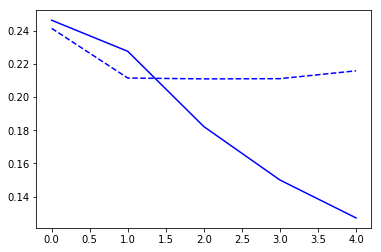

In [223]:
train_history_eprating_lstm = eprating_lstm.fit(lstm_X_train, lstm_y_train,
                                                batch_size=32, epochs=5,
                                                validation_data = [lstm_X_test, lstm_y_test],
                                                verbose=1)

plt.plot(train_history_eprating_lstm.history['loss'], 'b')
plt.plot(train_history_eprating_lstm.history['val_loss'], 'b--')

Any decrease in val loss? No, immediately increases, when using residuals as target. 

When the target was raw rating, the model did learn a little. Probably it was picking up on show or character specific words, which are now already taken by the summary terms, so there is less left to work with.

Showing the results of predicting raw rating (after standardising): good correlation on test set, after 3-5 epochs with lr=0.0002

[[1.         0.80426416]
 [0.80426416 1.        ]]
[[1.         0.39902299]
 [0.39902299 1.        ]]


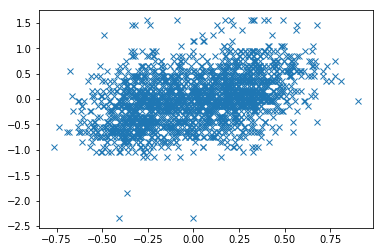

In [224]:
print(np.corrcoef(eprating_lstm.predict(lstm_X_train).flatten(), lstm_y_train))
print(np.corrcoef(eprating_lstm.predict(lstm_X_test).flatten(), lstm_y_test))

plt.plot(eprating_lstm.predict(lstm_X_test), lstm_y_test, 'x')

In [225]:
#And RMSE (may not be quite comparable because this is at the scene level):
#~0.45 for predicting raw rating after ~3 epochs with lr=0.0002

print('\nLSTM on raw rating: Corr = {:.3f}, RMSE = {:.4f}'.format(
    np.corrcoef(eprating_lstm.predict(lstm_X_test).flatten(), lstm_y_test)[0][1],
    ((lstm_y_test - eprating_lstm.predict(lstm_X_test).flatten())**2).mean()**0.5)
     )


LSTM on raw rating: Corr = 0.399, RMSE = 0.4646
